In [270]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
from pathlib import Path
os.chdir(Path(os.getcwd()).absolute().parent)
from bayes_opt import BayesianOptimization

## Original Implementation

In [271]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

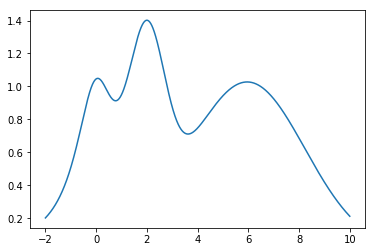

In [272]:
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y)

In [273]:
gp_params = {"alpha": 1e-5, "n_restarts_optimizer": 2}
bo = BayesianOptimization(target, {'x': (-2, 10)})

In [274]:
np.random.rand(6)
bo.explore({'x': [0, 4]})
bo.maximize(init_points=0, n_iter=1, acq='ei', xi=1e-4, kappa=5.,**gp_params)

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |    1.04564 |    0.0000 | 
    2 | 00m00s |    0.74746 |    4.0000 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    3 | 00m02s |    0.20166 |   -2.0000 | 


In [275]:
def posterior(bo, x, xmin=-2, xmax=10):
    xmin, xmax = -2, 10
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma = bo.gp.predict(x, return_std=True)
    return mu, sigma

def plot_gp(bo, x, y):
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(bo, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(bo.X.flatten(), bo.Y, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility = bo.util.utility(x, bo.gp, bo.Y.max()) ##0???
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

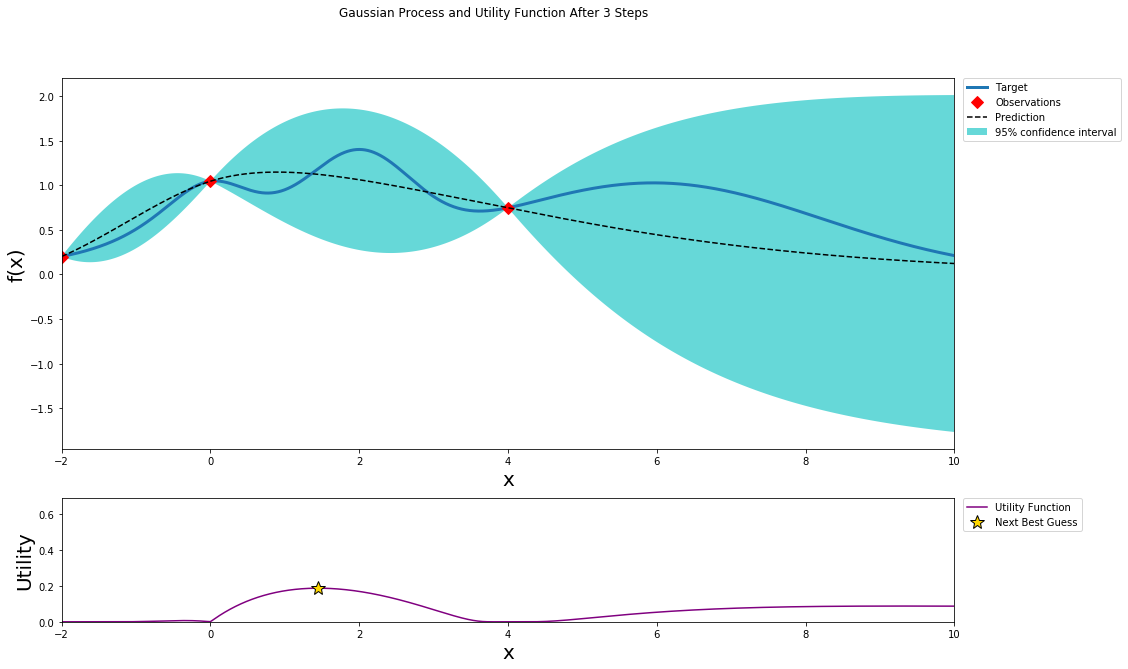

In [276]:
plot_gp(bo, x, y)

## new implementation

In [277]:
X, t = np.array([[0], [4], [-2]]), np.array([target(0), target(4), target(-2)])

# init_points = 2
# for i in range(2):
#     rand = np.random.randint(len(x))
#     X.append(x[rand])
#     t.append(y[rand])
# X = np.array(X)
# t = np.array(t).squeeze()


In [278]:
def my_posterior(gp, X, Y, x, xmin=-2, xmax=10):
    xmin, xmax = -2, 10
    mu, sigma = gp.predict(x, return_std=True)
    return mu, sigma

def my_plot_gp(gp, util, X, Y, x, y, **util_args):
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = my_posterior(gp, X, Y, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(X.flatten(), Y, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})


    utility = util.utility(x, gp, Y.max(), **util_args)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

In [279]:
import importlib
import bayesian_optimizer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

importlib.reload(bayesian_optimizer)
gp_params = {"alpha": 1e-5, "n_restarts_optimizer": 2}
candidate = bayesian_optimizer.get_candidate(X, t, [(-2, 10)], acq='ei', xi=1e-4, **gp_params)
candidate

Fitting Gaussian Processor Regressor
[2017-07-26 18:31:02,676] [bayesian_optimizer:178] [DEBUG] Fitting Gaussian Processor Regressor
Computing argmax_x of acquisition function
[2017-07-26 18:31:02,716] [bayesian_optimizer:182] [DEBUG] Computing argmax_x of acquisition function


array([ 1.47257308])

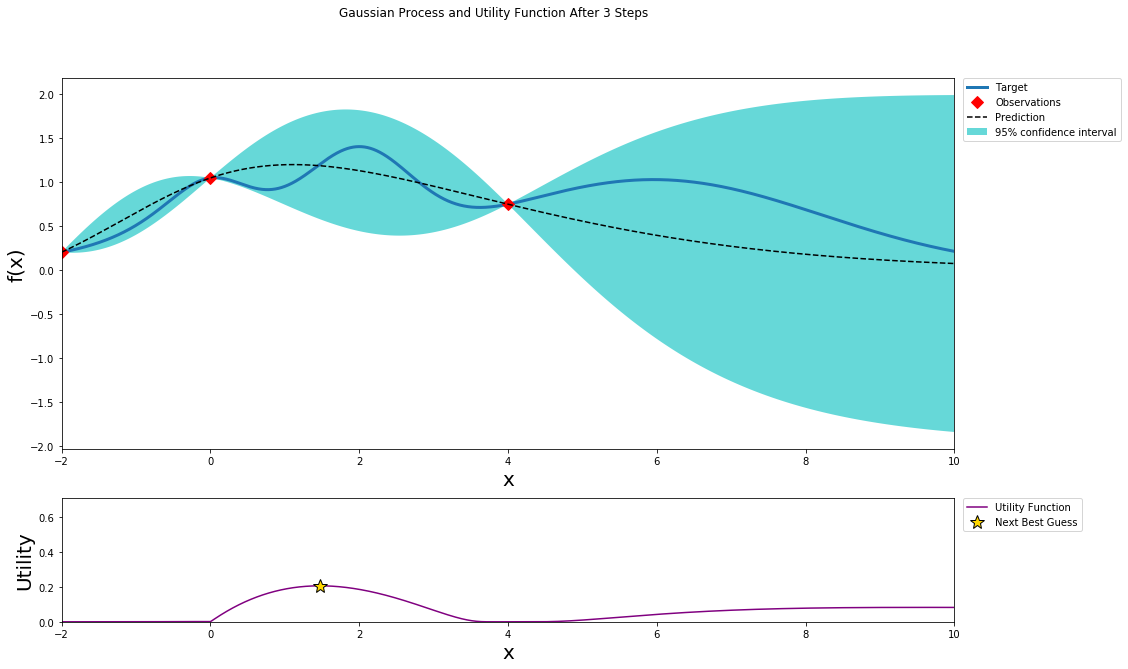

In [280]:
np.random.rand(6)
gp = GaussianProcessRegressor(
            kernel=Matern(nu=2.5),
            n_restarts_optimizer=25,
        )
gp.set_params(**gp_params)
gp.fit(X, Y)
util = bayesian_optimizer.UtilityFunction(kind='ei', kappa=0, xi=1e-4)
util_args = {}
# util_args = {"constraint": 0.7, "mean": np.mean(X), 'std':np.std()}
my_plot_gp(gp, util, X, t, x, y, **util_args)